In [29]:
from matplotlib import pyplot as plt

In [30]:
from IPython.display import display
from copy import copy

In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
from data_provider import TempuckeyVideoSentencePairsDataset as TempuckeyDataset
from data_provider import Normalize_VideoSentencePair
from layers.v2t import V2T
from eval_v2t import encode_data_v2t, calc_l2_distance, get_metrics , normalize_metrics, load_model
import utilities as utils

from numpy import linalg
import numpy as np
import argparse
import pdb
import torch 
import math

In [34]:
batch_size = 128
t_feat_len = 1
v_feat_len = 1
t_num_feats = 512
v_num_feats = 2048

data_dir = '/usr/local/data02/zahra/datasets/Tempuckey/sentence_segments'
video_feats_dir = 'feats/video/r2plus1d_resnet50_kinetics400'
text_feats_path = 'feats/text/universal/sentence_feats.pkl'
train_split_path = 'train.split.pkl'
valid_split_path = 'valid.split.pkl'
test_split_path = 'test.split.pkl'
train_valid_path = 'train_valid.split.pkl'
repo_dir = '/usr/local/extstore01/zahra/Video-Text-Retrieval_OOD'
output_dir = '/usr/local/extstore01/zahra/Video-Text-Retrieval_OOD/output'
experiments_dir = '/usr/local/extstore01/zahra/Video-Text-Retrieval_OOD/output/experiments/v2t'

v_feats_dir = f'{data_dir}/{video_feats_dir}'
t_feats_path = f'{data_dir}/{text_feats_path}'

train_split_path = f'{data_dir}/{train_split_path}'
valid_split_path = f'{data_dir}/{valid_split_path}'
test_split_path = f'{data_dir}/{test_split_path}'
train_valid_split_path = f'{data_dir}/{train_valid_path}'

dl_params = {'batch_size': batch_size,
    'shuffle': False,
    'num_workers': 1}

In [35]:
def get_experiment_names(path_):
    names = utils.get_filenames(path_)
    experiment_names = [p for p in names if p[:10]=='experiment']
    
    return experiment_names

In [36]:
def get_results(experiment_names):
    results = []
    relevance_scores = [round(i,1) for i in np.arange(0,0.8,.1)]
    for relevance_score in relevance_scores:
        data_ids = utils.load_picklefile(split_path)
        dataset = TempuckeyDataset(v_feats_dir, t_feats_path, data_ids, video_feat_seq_len=1, sent_feat_seq_len=1, transform=None, relevance_score=relevance_score)
        data_loader = torch.utils.data.DataLoader(dataset, **dl_params)

        if data_loader.__len__()<1:
            print('dataset is empty!')
            continue
        for experiment_name in experiment_names:
            model_v_path = f'{experiments_dir}/{experiment_name}/model_v_{experiment_name}.sd'
            model_v2t = load_model(model_v_path, v_num_feats)

            ids, pred_t, orig_t = encode_data_v2t(data_loader, model_v2t)

            dist_matrix_v2t = calc_l2_distance(orig_t, pred_t)
            metrics_v2t, ranks_v2t = get_metrics(dist_matrix_v2t)

            exp_metrics = normalize_metrics(metrics_v2t, n_samples_experiment = dataset.__len__())
            temp = [experiment_name, relevance_score]
            temp.extend(exp_metrics)

            results.append(temp)

    return results

In [37]:
def add_columns_to_df(df):
    # add loss_type as a column
    df['loss_type'] = 'unk'
    df.loc[df['experiment'].str.contains('contrastive'),'loss_type'] = 'cont'
    df.loc[df['experiment'].str.contains('mse'),'loss_type'] = 'mse'

    # add relevance score at training as a new column
    df['relevance_train'] = 0
    relevance_scores = [str(round(i,1)) for i in np.arange(0,0.8,.1)]

    for th in relevance_scores:
        val = f'_relevance_{th}_1x512_1x2048'
        df.loc[df['experiment'].str.contains(val),'relevance_train'] = th
    
    return df

In [38]:
experiment_names = []
experiment_names.extend(get_experiment_names(experiments_dir))

## Results on Test split

In [15]:
split_path = test_split_path
results_test = get_results(experiment_names)
results_test = pd.DataFrame(results_test, columns = ['experiment', 'relevance', 'R@1', 'R@5', 'R@10', 'MeanRank', 'MedRank'])

df = copy(results_test)

len dataset: 372
len dataset: 359
len dataset: 340
len dataset: 126
len dataset: 126
len dataset: 119
len dataset: 110
len dataset: 15


In [16]:
df = add_columns_to_df(df)

In [17]:
# get max results per category loss_type, relevance_train, relevance
# stats = ['mean', 'max']
stats = ['max']
series_max = df.groupby(['loss_type','relevance_train']).agg({'R@1': stats ,'R@5': stats,'R@10': stats})
df_max_r_1 = pd.DataFrame(series_max['R@1']['max'])
df_max_r_5 = pd.DataFrame(series_max['R@5']['max'])
df_max_r_10 = pd.DataFrame(series_max['R@10']['max'])

In [20]:
noise_th_training = [round(i,1) for i in np.arange(0,0.8,.1)]
noise_th_training

dataset_size = [2104, 2026, 1919, 684, 684, 629, 581, 81]

In [21]:
# recall@1 top results
r_at_1 = {}
r_at_1['cont'] = {}
r_at_1['mse'] = {}
for i in range(len(df_max_r_1)):
    l,th = df_max_r_1.iloc[i].name
    r_at_1[l][th] = float(df_max_r_1.iloc[i])
    
# recall@5 top results
r_at_5 = {}
r_at_5['cont'] = {}
r_at_5['mse'] = {}
for i in range(len(df_max_r_5)):
    l,th = df_max_r_5.iloc[i].name
    r_at_5[l][th] = float(df_max_r_5.iloc[i])
    
# recall@10 top results
r_at_10 = {}
r_at_10['cont'] = {}
r_at_10['mse'] = {}
for i in range(len(df_max_r_10)):
    l,th = df_max_r_10.iloc[i].name
    r_at_10[l][th] = float(df_max_r_10.iloc[i])
    

In [22]:
def plot_performance_data_size_vs_noise(x,y,z, cmap='Accent'):
    '''
    x: np.array noise thresholds
    y: np.array scaled performance values
    z: np.array scaled dataset size
    '''
    plt.figure(1, figsize=(6, 6), dpi=80)
    
    plt.plot(x, y, color='b', label='recall@1')
    plt.plot(x, z, color='r', label='dataset-size')
    plt.scatter(x, z, c = x, cmap=cmap, s=80)
    
    # plt.title = 'recall at K vs. noise'

    plt.xlabel = 'noise-level'
    plt.ylabel = 'recall@1'

    plt.legend()

    cbar = plt.colorbar(orientation='horizontal', extend = 'neither', ticks = [])

    ax = plt.gca()
    ax.set_xlabel('noise-level')
    ax.set_ylabel('scaled performance')

    plt.show()

In [23]:
def plot_performance_data_size_vs_noise_combined(x,y1,y2,z, cmap='Accent'):
    '''
    x: np.array noise thresholds
    y: np.array scaled performance values
    z: np.array scaled dataset size
    '''
    plt.figure(1, figsize=(7, 7), dpi=80)
    
    plt.plot(x, y1, color='g', label='MLP-6 (mse)')
    plt.plot(x, y2, color='b', label='MLP-6 (contrastive)')
    plt.plot(x, z, color='r', label='dataset-size')
    plt.scatter(x, z, c = x, cmap=cmap, s=80)
    
    # plt.title = 'recall at K vs. noise'

    plt.xlabel = 'noise-level'
    plt.ylabel = 'recall@1'

    plt.legend()

    cbar = plt.colorbar(orientation='horizontal', extend = 'neither', ticks = [])

    ax = plt.gca()
    ax.set_xlabel('noise-level')
    ax.set_ylabel('scaled performance')

    plt.show()

In [24]:
def get_max_results(data = [r_at_1, r_at_5, r_at_10], loss_type = 'mse', k = '1'):
    if k == '1':
        return data[0][loss_type]
    elif k == '5':
        return data[1][loss_type]
    elif k == '10':
        return data[2][loss_type]
    else:
        print ('Unknown K!!')
        return None
    

In [25]:
def recall_data_to_xyz(recall_data, dataset_size):

    x = np.array([10-r for r in range(len(recall_data.keys()))])

    y = np.array([float(r) for r in recall_data.values()])

    dataset_size = np.array(dataset_size)
    dataset_size_normed = dataset_size/dataset_size.max()
    z = dataset_size_normed

    assert len(x)==len(y) and len(x)==len(z)
    
    return x,y,z


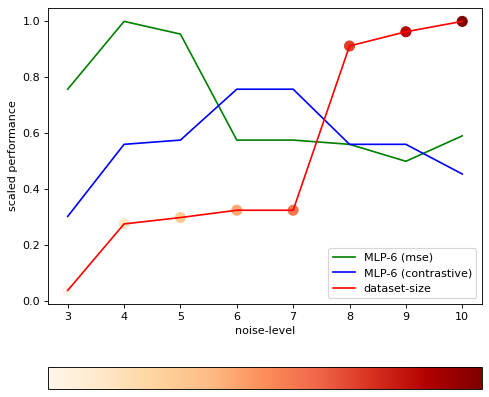

In [44]:
for k in ['1']:#,'5','10']:
    data = [r_at_1, r_at_5, r_at_10]

    # mse
    recall_data = get_max_results(data, loss_type = 'mse', k=k)
    x,y1,z = recall_data_to_xyz(recall_data, dataset_size)

    # contrastive
    recall_data = get_max_results(data, loss_type = 'cont', k=k)
    x,y2,z = recall_data_to_xyz(recall_data, dataset_size)

    y_max = max(y1.max(),y2.max())
    y1 = y1/y_max
    y2 = y2/y_max

    plot_performance_data_size_vs_noise_combined(x,y1,y2,z,cmap='OrRd')


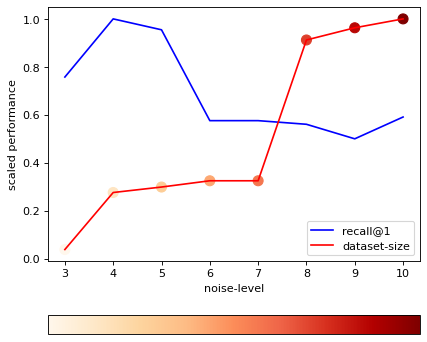

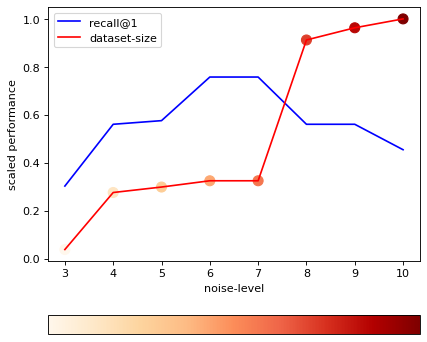

In [45]:
for k in ['1']: #,'5','10']:
    data = [r_at_1, r_at_5, r_at_10]

    # mse
    recall_data = get_max_results(data, loss_type = 'mse', k=k)
    x,y1,z = recall_data_to_xyz(recall_data, dataset_size)

    # contrastive
    recall_data = get_max_results(data, loss_type = 'cont', k=k)
    x,y2,z = recall_data_to_xyz(recall_data, dataset_size)

    y_max = max(y1.max(),y2.max())
    y1 = y1/y_max
    y2 = y2/y_max

    plot_performance_data_size_vs_noise(x,y1,z,cmap='OrRd')
    
    plot_performance_data_size_vs_noise(x,y2,z,cmap='OrRd')


In [39]:
import pickle as pkl

test_recall_max_path = f'{output_dir}/results/test_recall_max.pkl'
test_recall_df_path = f'{output_dir}/results/test_recall_df.pkl'
pkl.dump(series_max, open(test_recall_max_path,'wb'))
pkl.dump(df, open(test_recall_df_path,'wb'))

In [46]:

# split_path = train_valid_split_path
# results_train = get_results(experiment_names)
# results_train = pd.DataFrame(results_train, columns = ['experiment', 'relevance', 'R@1', 'R@5', 'R@10', 'MeanRank', 'MedRank'])

In [40]:
# split_path = '/usr/local/data02/zahra/datasets/Tempuckey/sentence_segments/train_valid.split.pkl'

# data_ids = utils.load_picklefile(split_path)
# relevance_scores = [round(i,1) for i in np.arange(0,0.8,.1)]
# for relevance_score in relevance_scores:
#     dataset = TempuckeyDataset(v_feats_dir, t_feats_path, data_ids, video_feat_seq_len=1, sent_feat_seq_len=1, transform=None, relevance_score=relevance_score)
#     data_loader = torch.utils.data.DataLoader(dataset, **dl_params)
#     print()

len dataset: 2104

len dataset: 2026

len dataset: 1919

len dataset: 684

len dataset: 684

len dataset: 629

len dataset: 581

len dataset: 81

